# Microsoft Movie Analysis
Author: Jennifer Ha
***

## Overview


## Business Problem

Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. 

In order to assist the stakeholders at Microsoft to make data-driven decision for their new business, we will be reviewing and analyzing datasets to provide a viable and profitable business option. The findings and recommendations will help the stakeholders with better understanding of movie industry, how to better spend their budget, and who to work with to drive a successful outcome.

***
Questions to consider:
* Which genres are the most profitable and yield the highest ROI?
* What is the ideal budget range to yield the highest ROI?
* Who are the top casts and directors in those genres that Microsoft should work with?
***

## Data
For this project, the following data sets from The Numbers and IMDb were used to answer the questions in the above.  

* `tn_movie_budgets`: This data set from The Numbers contains movie production budget, domestic, and international revenue amount by movie, which will be used to conduct ROI anaylsis. 

* `imdb_name_basics`: This data set from IMDb contains general movie information with movie title, runtime, genre(s). Every movie has a unique ID (`tconst`) assigned, which will be used as primary key/foreign key to join other imdb data sets.

* `imdb_title_principals`: This data set from IMDb contains job title for people who participated in a film with a unique ID (`nconst`) that can be used to identify individual participants. This dat set also includes a foreign key (`tconst`).

* `imdb_title_basics`: This dat set from IMDb contains names of individuals in the business with their profession title(s), movies they participated listed with the `tconst`, and their unique ID `nconst`.

### Prepare Data

In [176]:
#import libraries
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import seaborn as sns

from scipy import stats

### Clean Up tn_movie_budgets

In [177]:
#import the tn_movie_budgets and examine the data
tn_movie_budgets = pd.read_csv("zippedData/tn.movie_budgets.csv.gz")

#get summary of the DataFrame
tn_movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [178]:
#drop id since we don't need this column, and domestic_gross column because we will focus on international ROI
tn_movie_budgets = tn_movie_budgets.drop(['id','domestic_gross'], axis = 1)

In [179]:
#convert release_date to datetime and add a release_year column
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['release_year'] = tn_movie_budgets['release_date'].dt.year

#check data
tn_movie_budgets.head()

,release_date,movie,production_budget,worldwide_gross,release_year
0,2009-12-18,Avatar,"$425,000,000","$2,776,345,279",2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$1,045,663,875",2011
2,2019-06-07,Dark Phoenix,"$350,000,000","$149,762,350",2019
3,2015-05-01,Avengers: Age of Ultron,"$330,600,000","$1,403,013,963",2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$1,316,721,747",2017


In [180]:
#check for missing values
tn_movie_budgets.isna().sum()

release_date         0
movie                0
production_budget    0
worldwide_gross      0
release_year         0
dtype: int64

In [181]:
#convert currency with $ to integer
tn_movie_budgets[tn_movie_budgets.columns[2:]] = tn_movie_budgets[tn_movie_budgets.columns[2:]].replace('[\$,]', '', regex=True).astype(int)

#check data
tn_movie_budgets.head()

,release_date,movie,production_budget,worldwide_gross,release_year
0,2009-12-18,Avatar,425000000,2776345279,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,2019-06-07,Dark Phoenix,350000000,149762350,2019
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017


In [182]:
#examine the data if there are any rows with value 0
print(len(tn_movie_budgets[tn_movie_budgets['production_budget'] > 0]) / len(tn_movie_budgets))
print(len(tn_movie_budgets[tn_movie_budgets['worldwide_gross'] > 0]) / len(tn_movie_budgets))

1.0
0.936527153234175


In [183]:
#drop rows with value 0 in worldwide_gross column since 93.6% of data have associated revenue values
tn_movie_budgets = tn_movie_budgets[tn_movie_budgets['worldwide_gross'] > 0]

#check data
tn_movie_budgets.head()

,release_date,movie,production_budget,worldwide_gross,release_year
0,2009-12-18,Avatar,425000000,2776345279,2009
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011
2,2019-06-07,Dark Phoenix,350000000,149762350,2019
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017


In [184]:
#calculate ROI and add the column in the DataFrame
def roi(budget, gross):
    return (gross - budget) / budget * 100
tn_movie_budgets['ROI'] = roi(tn_movie_budgets['production_budget'], tn_movie_budgets['worldwide_gross'])

#check data
tn_movie_budgets

,release_date,movie,production_budget,worldwide_gross,release_year,ROI
0,2009-12-18,Avatar,425000000,2776345279,2009,553.257713
1,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,1045663875,2011,154.667286
2,2019-06-07,Dark Phoenix,350000000,149762350,2019,-57.210757
3,2015-05-01,Avengers: Age of Ultron,330600000,1403013963,2015,324.384139
4,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,1316721747,2017,315.369636
...,...,...,...,...,...,...
5775,2006-05-26,Cavite,7000,71644,2006,923.485714
5776,2004-12-31,The Mongol King,7000,900,2004,-87.142857
5778,1999-04-02,Following,6000,240495,1999,3908.250000
5779,2005-07-13,Return to the Land of Wonders,5000,1338,2005,-73.240000


### Clean Up imdb_title_basics

In [185]:
#import the file and examine the data
imdb_title_basics = pd.read_csv("zippedData/imdb.title.basics.csv.gz")

imdb_title_basics.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [186]:
#set tconst column as the index since it will be used as primary key/foreign key when joining tables
imdb_title_basics = imdb_title_basics.set_index('tconst')

#check data
imdb_title_basics.head()

,primary_title,original_title,start_year,runtime_minutes,genres
tconst,,,,,
tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [187]:
#drop original_title and runtime_minutes columns as we don't need this data for our analysis
imdb_title_basics = imdb_title_basics.drop(['original_title','runtime_minutes'], axis = 1)

#check data
imdb_title_basics.head()

,primary_title,start_year,genres
tconst,,,
tt0063540,Sunghursh,2013,"Action,Crime,Drama"
tt0066787,One Day Before the Rainy Season,2019,"Biography,Drama"
tt0069049,The Other Side of the Wind,2018,Drama
tt0069204,Sabse Bada Sukh,2018,"Comedy,Drama"
tt0100275,The Wandering Soap Opera,2017,"Comedy,Drama,Fantasy"


In [188]:
#check for missing values
imdb_title_basics.isna().sum()

primary_title       0
start_year          0
genres           5408
dtype: int64

In [189]:
#examine genre column to determine whether we shoup drop N/As or replace them with 'Unknown'
imdb_title_basics['genres'].isna().sum()/len(imdb_title_basics)

0.037004598204510616

In [190]:
#drop rows with N/A in genres column since only 3.7% of data shows N/A
imdb_title_basics = imdb_title_basics.dropna(subset = ['genres'])

In [191]:
#convert genres to list
imdb_title_basics['genres'] = imdb_title_basics['genres'].map(lambda x: x.split(','))

#check data
imdb_title_basics.head()

,primary_title,start_year,genres
tconst,,,
tt0063540,Sunghursh,2013,"[Action, Crime, Drama]"
tt0066787,One Day Before the Rainy Season,2019,"[Biography, Drama]"
tt0069049,The Other Side of the Wind,2018,[Drama]
tt0069204,Sabse Bada Sukh,2018,"[Comedy, Drama]"
tt0100275,The Wandering Soap Opera,2017,"[Comedy, Drama, Fantasy]"


### Clean Up imdb_title_principals

In [192]:
#import the file and examine the data
imdb_title_principals = pd.read_csv("zippedData/imdb.title.principals.csv.gz")

imdb_title_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [193]:
#set tconst column as the index since it will be used as primary key/foreign key when joining tables
imdb_title_principals = imdb_title_principals.set_index('tconst')

#check data
imdb_title_principals.head()

,ordering,nconst,category,job,characters
tconst,,,,,
tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
tt0111414,2,nm0398271,director,NaN,NaN
tt0111414,3,nm3739909,producer,producer,NaN
tt0323808,10,nm0059247,editor,NaN,NaN
tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


In [194]:
#drop ordering, job, and characters columns as we don't need this data for our analysis
imdb_title_principals = imdb_title_principals.drop(['ordering','job','characters'], axis = 1)

#check data
imdb_title_principals.head()

,nconst,category
tconst,,
tt0111414,nm0246005,actor
tt0111414,nm0398271,director
tt0111414,nm3739909,producer
tt0323808,nm0059247,editor
tt0323808,nm3579312,actress


In [195]:
#check for missing values
imdb_title_principals.isna().sum()

nconst      0
category    0
dtype: int64

In [196]:
#examine the job titles and value counts in category column
imdb_title_principals.category.value_counts()

actor                  256718
director               146393
actress                146208
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65424
editor                  55512
production_designer      9373
archive_footage          3307
archive_sound              16
Name: category, dtype: int64

In [197]:
#replace 'actress' with 'actors' 
imdb_title_principals['category'] = imdb_title_principals.category.str.replace('actress','actor')

#check data
imdb_title_principals.head()

,nconst,category
tconst,,
tt0111414,nm0246005,actor
tt0111414,nm0398271,director
tt0111414,nm3739909,producer
tt0323808,nm0059247,editor
tt0323808,nm3579312,actor


### Clean Up imdb_name_basics

In [198]:
#import the file and examine the data
imdb_name_basics = pd.read_csv("zippedData/imdb.name.basics.csv.gz")

imdb_name_basics.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [199]:
#set nconst column as the index since it will be used as primary key/foreign key when joining tables
imdb_name_basics = imdb_name_basics.set_index('nconst')

#check data
imdb_name_basics.head()

,primary_name,birth_year,death_year,primary_profession,known_for_titles
nconst,,,,,
nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [200]:
#drop birth_year, death_year, primary_profession, and 'known_for_titles' as we don't need this data for our analysis
imdb_name_basics = imdb_name_basics.drop(['birth_year','death_year','primary_profession','known_for_titles'], axis = 1)

#check data
imdb_name_basics.head()

,primary_name
nconst,
nm0061671,Mary Ellen Bauder
nm0061865,Joseph Bauer
nm0062070,Bruce Baum
nm0062195,Axel Baumann
nm0062798,Pete Baxter


## Join Datasets

### Merge tn_movie_budgets and imdb_title_basics as df

Combine `tn_movie_budget` and `imdb_title_basics` DataFrame to create a new DataFrame called df. Since the column names are different, we are going to explicitly mention both the column names using 'left_on' and 'right_on' arguments. Then, we will remove the duplicate columns as a result of the merge, and reset the index to 'tconst' so that we can easily use the index as the primary key when joining with other imdb tables for additional analyes.

In [201]:
#merge tn_movie_budgets and imdb_title_basics as df
df = pd.merge(imdb_title_basics.reset_index(), tn_movie_budgets,
             left_on=['primary_title', 'start_year'],
             right_on=['movie', 'release_year'])

#drop duplicate columns (primary_title, start_year)
df = df.drop(['primary_title','start_year'], axis = 1)

#reset index to tconst
df = df.set_index('tconst')

#check data
df.head()

,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI
tconst,,,,,,,
tt0249516,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0359950,"[Adventure, Comedy, Drama]",2013-12-25,The Secret Life of Walter Mitty,91000000,187861183,2013,106.440860
tt0365907,"[Action, Crime, Drama]",2014-09-19,A Walk Among the Tombstones,28000000,62108587,2014,121.816382
tt0369610,"[Action, Adventure, Sci-Fi]",2015-06-12,Jurassic World,215000000,1648854864,2015,666.909239
tt0376136,"[Comedy, Drama]",2011-10-28,The Rum Diary,45000000,21544732,2011,-52.122818


In [202]:
#check for duplicates since df DataFrame will serve as our primary table for future analysis. 
df[df.duplicated(
        subset = ['movie', 'release_year'],
        keep = False)].shape

(94, 7)

For higher accuracy and simplicity of this analysis project, we will remove these 94 rows from this DataFrame.

In [203]:
#drop duplicates
df = df[~df.duplicated(
        subset = ['movie', 'release_year'],
        keep=False)]

#check data
df.head()

,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI
tconst,,,,,,,
tt0249516,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0359950,"[Adventure, Comedy, Drama]",2013-12-25,The Secret Life of Walter Mitty,91000000,187861183,2013,106.440860
tt0365907,"[Action, Crime, Drama]",2014-09-19,A Walk Among the Tombstones,28000000,62108587,2014,121.816382
tt0369610,"[Action, Adventure, Sci-Fi]",2015-06-12,Jurassic World,215000000,1648854864,2015,666.909239
tt0376136,"[Comedy, Drama]",2011-10-28,The Rum Diary,45000000,21544732,2011,-52.122818


### Join df with imdb_title_principals

Update the df DataFrame by joining imdb_title_principals using an inner join, and the output will automatically drop N/A values. There is no need to specify where the join will occur since we have already reset indices for this purpose when cleaning the data.

In [204]:
#join df with imdb_title_principals
df = imdb_title_principals.join(df, how='inner')

df.head()

,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI
tconst,,,,,,,,,
tt0249516,nm0257258,producer,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0240381,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0240380,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0000221,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209
tt0249516,nm0519456,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209


In [205]:
#Check for people who appears more than once in a movie
df.reset_index().duplicated(subset=['tconst', 'nconst']).sum()

0

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13144 entries, tt0249516 to tt9024106
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   nconst             13144 non-null  object        
 1   category           13144 non-null  object        
 2   genres             13144 non-null  object        
 3   release_date       13144 non-null  datetime64[ns]
 4   movie              13144 non-null  object        
 5   production_budget  13144 non-null  int64         
 6   worldwide_gross    13144 non-null  int64         
 7   release_year       13144 non-null  int64         
 8   ROI                13144 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 1.0+ MB


### Join df with imbd_name_basics

In [207]:
df = pd.merge(df.reset_index(),imdb_name_basics,how = 'inner', on = 'nconst')

df

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI,primary_name
0,tt0249516,nm0257258,producer,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
1,tt0249516,nm0240381,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff
2,tt0249516,nm0240380,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Haylie Duff
3,tt0249516,nm0000221,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Charlie Sheen
4,tt0249516,nm0519456,actor,"[Action, Animation, Comedy]",2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Eva Longoria
...,...,...,...,...,...,...,...,...,...,...,...
13139,tt9024106,nm0478750,actor,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Robia Scott
13140,tt9024106,nm5237225,actor,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Jared Lotz
13141,tt9024106,nm2445956,producer,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Chris Jones
13142,tt9024106,nm7839151,producer,"[Biography, Drama]",2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp


## Split Genres to Separate Rows

Use `explode` function to transform each element in a list in 'genres' column. This will allow us to easily run analysis by **genres**.

In [208]:
df = df.explode('genres')
df.head()

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI,primary_name
0,tt0249516,nm0257258,producer,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
0,tt0249516,nm0257258,producer,Comedy,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman
1,tt0249516,nm0240381,actor,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff
1,tt0249516,nm0240381,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff


## Identify and Remove Outliers

We have now completed cleaning up and joining the DataFrames that are required for this project. However, we need to further examine the data before we start data exploration to check if there are any outliers that should be removed.

First, we will examine the overall production_budget against ROI, and will create a fuction so that we can re-visualize the data after removing the outliers.

In [209]:
#define a function to visualize scatter plots with outliers
def scatter_plot(df, x ='production_budget', y = 'ROI'):
    
    #create the plot 
    f, ax = plt.subplots(figsize = (10,7))

    #generate a scatter plot
    ax.scatter(data = df,
           x = 'production_budget', 
           y= 'ROI')

    #add labels for x and y axes
    ax.set_xlabel('Production Budget')
    ax.set_ylabel('ROI')

    #add a title for the plot
    ax.set_title('Production Budget vs. ROI')
    ;

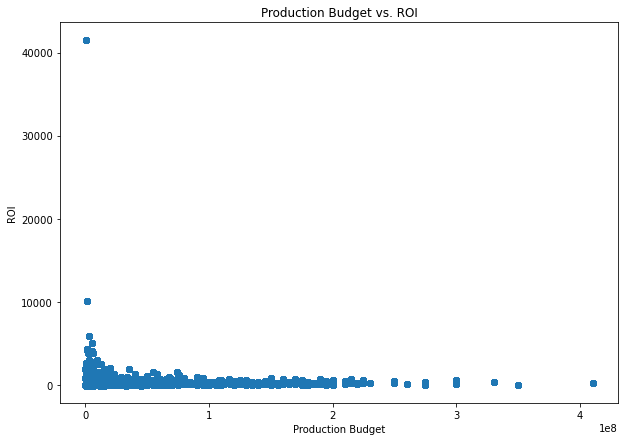

In [210]:
scatter_plot(df)

### Z Score Method
Using a [z-score method](https://www.ctspedia.org/do/view/CTSpedia/OutLier#:~:text=Any%20z%2Dscore%20greater%20than,standard%20deviations%20from%20the%20mean.&text=Thus%20the%20z%2Dscore%20when,%2D%200.6549541)%2F0.4165770%20%3D%203.228805.), we will clean up the data by removing data points with z-score greater than 3. For this project, we can ignore checking data points with z-score less than 3 because ROI cannot be less than -100%.

In [211]:
#calculate z-score on ROI and create a new column to show the z-score in the DataFrame
df['ROI_zscore'] = stats.zscore(df['ROI'])

#remove rows with z-score greater than 3
df = df[df['ROI_zscore'] < 3]

df

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI,primary_name,ROI_zscore
0,tt0249516,nm0257258,producer,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
0,tt0249516,nm0257258,producer,Comedy,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732
1,tt0249516,nm0240381,actor,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff,-0.300732
1,tt0249516,nm0240381,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff,-0.300732
...,...,...,...,...,...,...,...,...,...,...,...,...
13141,tt9024106,nm2445956,producer,Drama,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Chris Jones,-0.073205
13142,tt9024106,nm7839151,producer,Biography,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp,-0.073205
13142,tt9024106,nm7839151,producer,Drama,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Joe Knopp,-0.073205
13143,tt9024106,nm0498920,producer,Biography,2019-03-29,Unplanned,6000000,18107621,2019,201.793683,Daryl C. Lefever,-0.073205


Now, vusualize the updated DataFrame after removing rows with z-score greater 3.

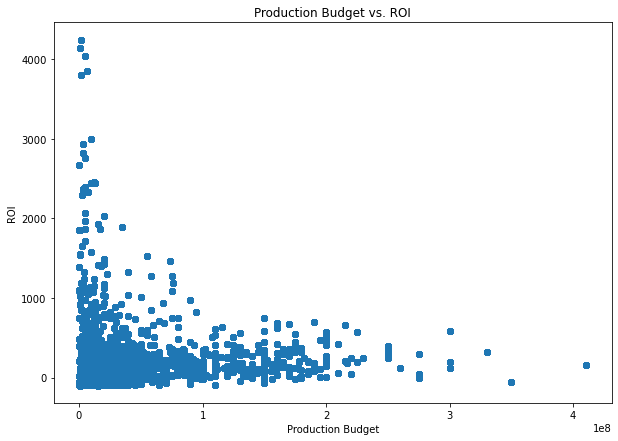

In [212]:
scatter_plot(df)

The scatter plot looks so much better! Now that we have cleaned up the overall DataFrame with z-score calculation on ROI, we want to examine the data more thoroughly. Let's take a look at ROI by genre - create a box plot with outliers.

In [213]:
#define a function to visualize box plots with outliers
def box_plot(df, x ='genres', y = 'ROI'):
    
    #create the plot 
    f, ax = plt.subplots(figsize = (15,7))

    #generate a box plot
    sns.boxplot(data = df,
           x = 'genres', 
           y= 'ROI',
           showfliers = True)
    
    plt.xticks(rotation = 45)

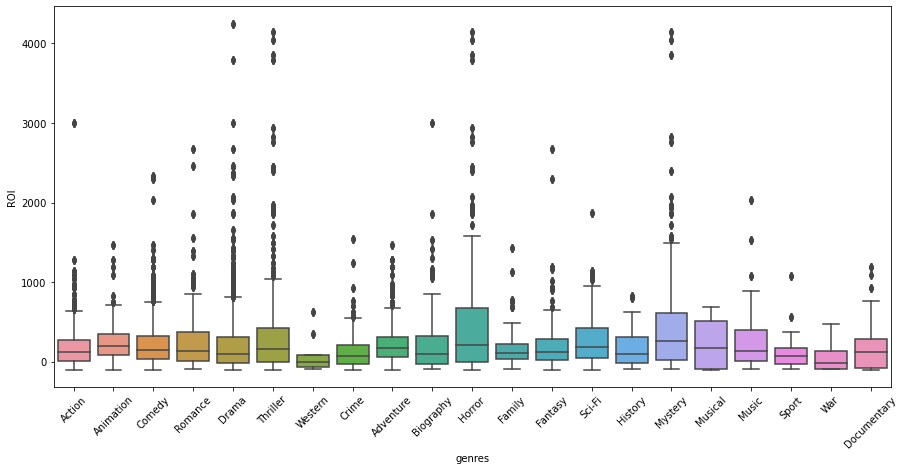

In [214]:
box_plot(df)

### 1.5xIQR Rule

Here, we are going to use the [1.5xIQR rule](https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule#:~:text=A%20commonly%20used%20rule%20says,or%20below%20the%20first%20quartile.), which defines a data point as an outlier if it is more than '1.5 * IQR' above the thrid quartile or less than '1.5 * IQR' below the first quartile. For this project, we can ignore outliers less than '1.5 * IQR' because ROI cannot be less than -100%.

Let's create a new DataFrame  called iqr to calculate the upper threshold that will be used to identify the high outliers.

In [215]:
#create an empty DataFrame
iqr = pd.DataFrame()

#calculate Quartile 1
iqr['Q1'] = df.groupby('genres').ROI.quantile(.25)

#calculate Quartile 3
iqr['Q3'] = df.groupby('genres').ROI.quantile(.75)

#calculate interquartile range
iqr['IQR'] = iqr['Q3'] - iqr['Q1']

#calculate the upper threshold
iqr['upper_threshold'] = iqr['Q3'] + 1.5*iqr['IQR']

#check data  
iqr

,Q1,Q3,IQR,upper_threshold
genres,,,,
Action,12.515718,269.713673,257.197955,655.510605
Adventure,55.974192,306.801427,250.827235,683.042280
Animation,86.577085,345.300955,258.723870,733.386761
Biography,-26.218484,322.261705,348.480189,844.981989
Comedy,27.430332,319.246700,291.816368,756.971252
Crime,-26.138270,207.666667,233.804937,558.374072
Documentary,-79.944000,289.962850,369.906850,844.823125
Drama,-19.907396,311.539470,331.446865,808.709768
Family,32.972215,226.110043,193.137828,515.816785


In [216]:
#create a new column in df to map the calculated upper threshold
df['iqr_upper_threshold'] = df['genres'].map(iqr['upper_threshold'])

#remove rows with the upper outliers
df = df[df['ROI'] < df['iqr_upper_threshold']]

#check data
df.head()

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI,primary_name,ROI_zscore,iqr_upper_threshold
0,tt0249516,nm0257258,producer,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732,655.510605
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732,733.386761
0,tt0249516,nm0257258,producer,Comedy,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732,756.971252
1,tt0249516,nm0240381,actor,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff,-0.300732,655.510605
1,tt0249516,nm0240381,actor,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Hilary Duff,-0.300732,733.386761


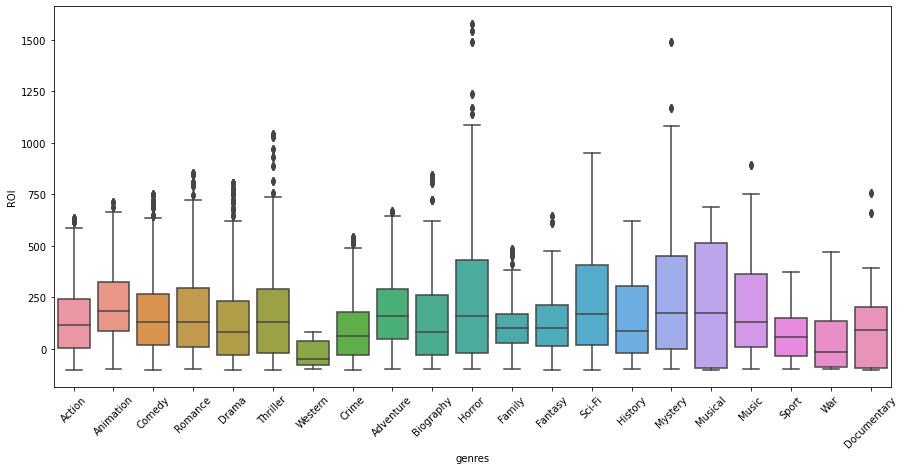

In [217]:
box_plot(df)

There are still some outliers but this box plot looks much better after we cleaned up the DataFrame using 1.5xIQR rule. 

## Questions

### Question 1: Which genres are the most profitable and yield the highest ROI?
To answer this question, we want to make sure we have accurate movie counts in each genre. Therefore, we need to clean up the data again because genres by movie are showing up more than once due to multiple individuals/roles in a movie.

In [218]:
#remove duplicate genres by movie
df_genres = df[~df.duplicated(subset=['tconst', 'genres'])]

df_genres

,tconst,nconst,category,genres,release_date,movie,production_budget,worldwide_gross,release_year,ROI,primary_name,ROI_zscore,iqr_upper_threshold
0,tt0249516,nm0257258,producer,Action,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732,655.510605
0,tt0249516,nm0257258,producer,Animation,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732,733.386761
0,tt0249516,nm0257258,producer,Comedy,2012-12-31,Foodfight!,45000000,73706,2012,-99.836209,Robert Engelman,-0.300732,756.971252
5,tt1563742,nm0519456,actor,Comedy,2018-05-04,Overboard,12000000,85369830,2018,611.415250,Eva Longoria,0.235783,756.971252
5,tt1563742,nm0519456,actor,Romance,2018-05-04,Overboard,12000000,85369830,2018,611.415250,Eva Longoria,0.235783,900.945423
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13095,tt7535780,nm3414570,actor,Documentary,2017-02-17,The Great Wall,150000000,334486852,2017,122.991235,Nicolette Creighton,-0.132648,844.823125
13114,tt8043306,nm9590185,cinematographer,Action,2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933,Zain Haleem,-0.295887,655.510605
13114,tt8043306,nm9590185,cinematographer,Comedy,2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933,Zain Haleem,-0.295887,756.971252
13114,tt8043306,nm9590185,cinematographer,Crime,2018-07-20,Teefa in Trouble,1500000,98806,2018,-93.412933,Zain Haleem,-0.295887,558.374072


Let's review median ROI by genre for this exercise. We will focus on median ROI rather than average ROI because some genres were showing skewed distributions in the box plot.

In [219]:
#calculate median ROI by genre 
median_ROI_genre = df_genres[['genres','ROI']].groupby('genres').median()

#sort data
median_ROI_genre = median_ROI_genre.sort_values(by = 'ROI', ascending = False)

#check data
median_ROI_genre

,ROI
genres,
Animation,183.882673
Musical,173.752303
Mystery,173.536887
Sci-Fi,169.771889
Horror,159.142558
Adventure,158.546312
Comedy,129.975758
Thriller,129.252657
Romance,128.318773


We will drop genres with negative median ROI values since our goal is to successfully generate profit on this new business!

In [220]:
#drop genres with negative median ROI values
median_ROI_genre = median_ROI_genre[median_ROI_genre['ROI'] > 0]

#check data
median_ROI_genre

,ROI
genres,
Animation,183.882673
Musical,173.752303
Mystery,173.536887
Sci-Fi,169.771889
Horror,159.142558
Adventure,158.546312
Comedy,129.975758
Thriller,129.252657
Romance,128.318773


Now let's plot the data.

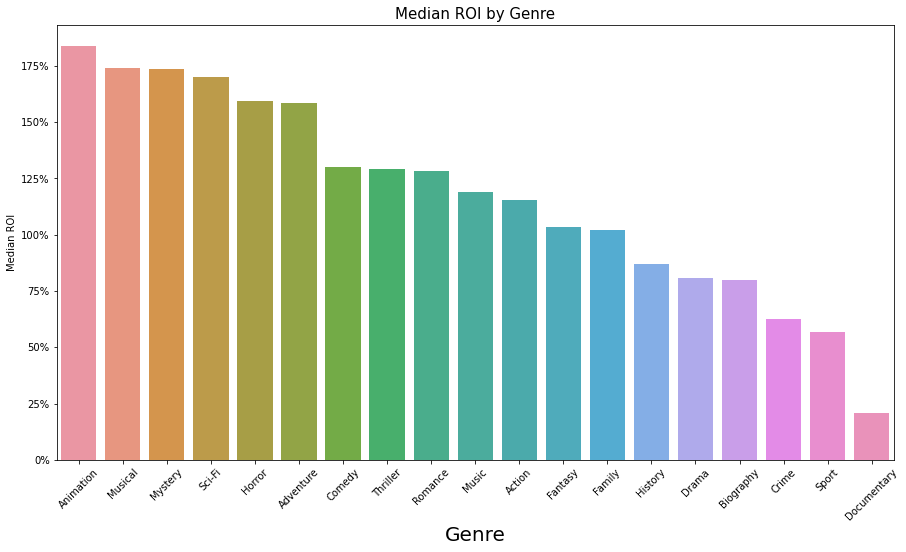

In [221]:
#create the plot
fig, ax = plt.subplots(figsize = (15, 8))

#Generate a bar graph
ax = sns.barplot(x = median_ROI_genre.index, 
                 y = median_ROI_genre['ROI'])

#add a title for the plot
plt.title('Median ROI by Genre', fontsize = 15)

#add labels for x and y axes
plt.xlabel('Genre', fontsize = 20)
plt.ylabel('Median ROI')

#rotate x-ticks
plt.xticks(rotation=45)

#add % to y-labels
ax.yaxis.set_major_formatter(mtick.PercentFormatter())


In [266]:
top_genres = list(median_ROI_genre[:4].index)

top_genres

['Animation', 'Musical', 'Mystery', 'Sci-Fi']

<ipython-input-310-6ec961448d22>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_df['date_ordinal'] = pd.to_datetime(plot_df['release_date']).apply(lambda date: date.toordinal())


''

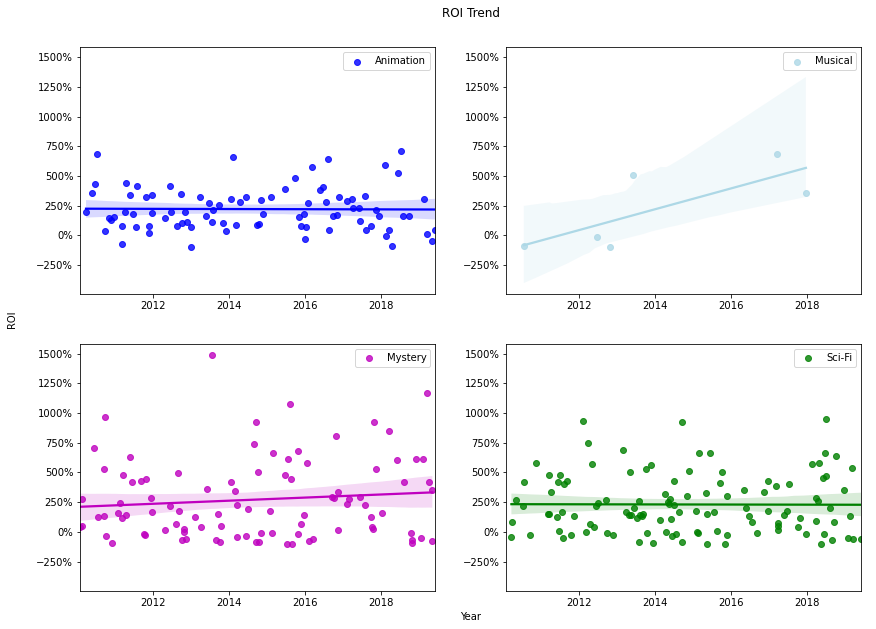

In [310]:
#remove duplicate genres by movie
trend_df = df[~df.duplicated(subset=['tconst', 'genres'])]

#get a date ordinal version of the release date so we can rename the x axis later
trend_df['date_ordinal'] = pd.to_datetime(plot_df['release_date']).apply(lambda date: date.toordinal())

#create a 4x4 subplot & set same x and y axes on all plots
fig, axs = plt.subplots(2, 2, figsize = (14,10), sharex=True, sharey=True)

#choose colors to be used
colors = ['b', 'lightblue', 'm', 'g']

#create tick marks from 2012 to 2020, with 2 year interval.
ticks = []

for year in range(2012, 2020, 2):
    
    #YYYY-01-01
    year = '-'.join([str(year),'01','01'])
    
    #append date ordinal of year to ticks
    ticks.append(pd.to_datetime(year).toordinal())

#create labels for x axis
x_labels = [dt.date.fromordinal(int(year)).year for year in ticks]


#create the subplots
for i in range(len(top_genres)):
    ax = axs[i//2][i%2]
    sns.regplot(data = trend_df[trend_df['genres'] == top_genres[i]],
                x = 'date_ordinal',
                y = 'ROI',
                color = colors[i],
                label = top_genres[i],
                ax = ax)
    
    #label each boxplot
    ax.legend()
    
    #set our x axis tick marks with ticks
    ax.set_xticks(ticks)
    
    #use the created x_labels for x-label
    ax.set_xticklabels(x_labels)

    #hide axis labels on subplots - we will create axis labels for the fig
    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)
    
    #set tick parameters for subplots
    ax.tick_params( bottom = True,
                    left = True,
                    labelbottom = True,
                    labelleft = True,
                    direction = 'out')
    
    # add % to y-labels
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())


#set subplot grid paratmeters
fig.add_subplot(1,1,1, frameon = False)

#set plot tick parameters
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

#add a title for the plot
plt.title('ROI Trend', pad=30)

#add labels for x and y axes for the plot
plt.ylabel("ROI", labelpad=40)
plt.xlabel("Year")

;

#### Animation, Musical, Mystery, and Sci-Fi win!
Analyzing the median ROI by genre, I advise the stakeholders at Microsoft to consider producing Animation, Musical, Mystery, and Sci-Fi movies to showcase the success of their new business with profitability. Looking at the trend in each of these genres, making a musical movie might be a bit risky since there are only few data point presented. Out of the remaining genres, mystery seems to be the most profitable genre.

### Question 2: What is the ideal budget range to yield the highest ROI?

### Question 3: Who are the top casts and directors in those genres that Microsoft should work with?

## Conclusions

## Further Analysis

***
## For More Information